In [2]:
import keras
import random
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

In [3]:
from imblearn.over_sampling import SMOTE

In [6]:
from imblearn.under_sampling import RandomUnderSampler

In [9]:
train_data = pd.read_pickle('final_train_data.pkl')

In [10]:
# Feature selection
X = train_data.drop(['isFraud'], axis=1)
y = train_data['isFraud']
# split the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)


In [8]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(911646, 171)
(911646,)


In [9]:
rus = RandomUnderSampler(random_state=0, sampling_strategy=0.9)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [8]:
y_train_smote.value_counts(normalize=True)

isFraud
0    0.5
1    0.5
Name: proportion, dtype: float64

In [11]:
y_train_resampled.value_counts(normalize=True)

isFraud
0    0.52631
1    0.47369
Name: proportion, dtype: float64

In [9]:
K.clear_session()

In [18]:
# create a checkpoint callback to save model based on validation recall values
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint(
    filepath="./model_rework/base_model_logloss_{val_loss:.2f}_auc_{val_auc:.2f}_checkpoint.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

# create earlystopping callback based on val_recall
early_stopping_callback = EarlyStopping(monitor="val_auc", mode="max", patience=10)


# create reduce lr on plateau callback
reduce_lr = ReduceLROnPlateau(monitor="val_auc", mode="max", patience=5, verbose=1, factor=0.1)
# create a callback list
callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr]

# create model function

def create_baseline_model(optimizer):
    # Create a baseline ANN model using keras for predicting binary classes of fraud
    # define ANN model
    model = keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=[X_train_smote.shape[1]]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # add recall and auc as metrics
    # recall = tf.keras.metrics.Recall(name='recall')
    auc = tf.keras.metrics.AUC(name='auc')

    # compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[auc])

    return model


## Undersampled Data

In [19]:
# choose adam as optimizer
from keras.optimizers import Adam
adam = Adam(learning_rate=0.003)
model = create_baseline_model(adam)
history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=512, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

Epoch 1/100
69/69 [==============================] - ETA: 0s - loss: 25.5741 - auc: 0.5284
Epoch 1: val_auc improved from -inf to 0.50080, saving model to ./model_rework/base_model_logloss_0.69_auc_0.50_checkpoint.h5
69/69 [==============================] - 62s 912ms/step - loss: 25.5741 - auc: 0.5284 - val_loss: 0.6902 - val_auc: 0.5008 - lr: 0.0030
Epoch 2/100
67/69 [============================>.] - ETA: 0s - loss: 0.6960 - auc: 0.5230
Epoch 2: val_auc improved from 0.50080 to 0.54925, saving model to ./model_rework/base_model_logloss_0.68_auc_0.55_checkpoint.h5
69/69 [==============================] - 2s 25ms/step - loss: 0.6960 - auc: 0.5231 - val_loss: 0.6777 - val_auc: 0.5492 - lr: 0.0030
Epoch 3/100
64/69 [==========================>...] - ETA: 0s - loss: 0.6911 - auc: 0.5324
Epoch 3: val_auc improved from 0.54925 to 0.55369, saving model to ./model_rework/base_model_logloss_0.66_auc_0.55_checkpoint.h5
69/69 [==============================] - 2s 23ms/step - loss: 0.6909 - auc: 

In [4]:
import seaborn as sns

<Axes: xlabel='epoch', ylabel='auc'>

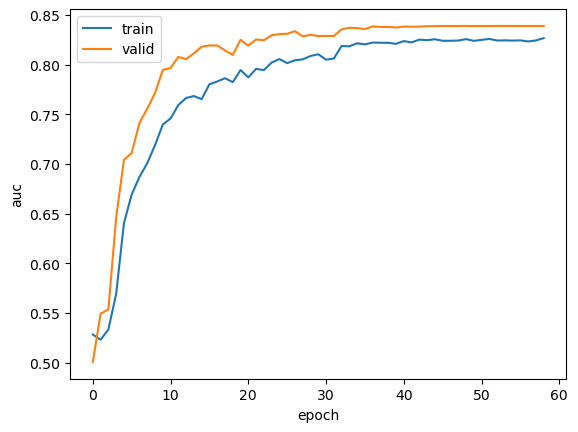

In [22]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

sns.lineplot(data = history_df, x='epoch', y='auc', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_auc', label='valid')

In [23]:
model = keras.models.load_model('model_rework/base_model_logloss_0.41_auc_0.84_checkpoint.h5')

In [5]:
from sklearn.metrics import auc, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

In [26]:
y_pred = model.predict(X_val)

3691/3691 [==============================] - 5s 1ms/step


In [28]:
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

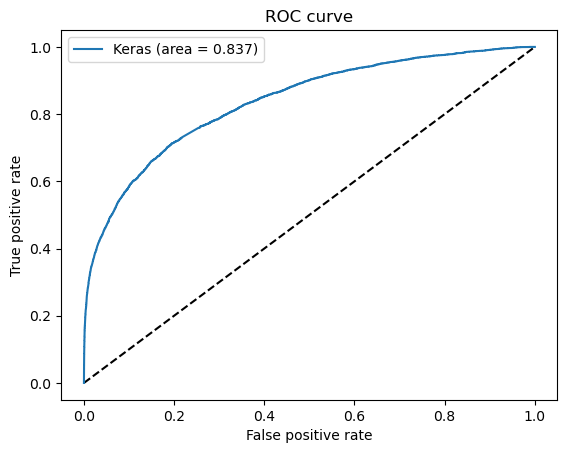

In [29]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [30]:
temp = X_val.copy()
temp['predicted'] = y_pred
temp['true'] = y_val
fraud_cases = temp[temp['true'] == 1]
non_fraud_cases = temp[temp['true']==0]

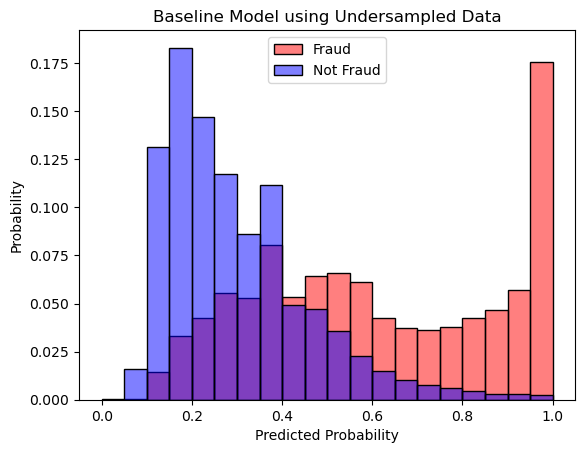

In [32]:
fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Baseline Model using Undersampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

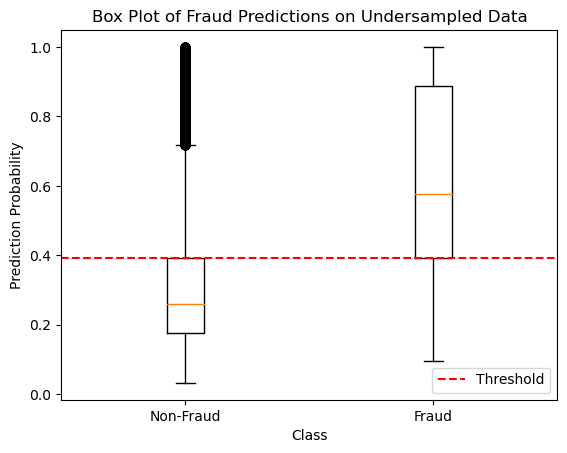

In [62]:
fraud_cases = y_pred[y_val==1]
non_fraud_cases = y_pred[y_val==0]
threshold = 0.392
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions on Undersampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Based on this, we can decide that the threshold is 0.39. Let's calculate the confusion matrix

In [71]:
y_pred_binary = (y_pred > 0.39).astype(int)
cm = confusion_matrix(y_val, y_pred_binary)

In [72]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

[Text(0, 0.5, 'Non Fraud'), Text(0, 1.5, 'Fraud')]

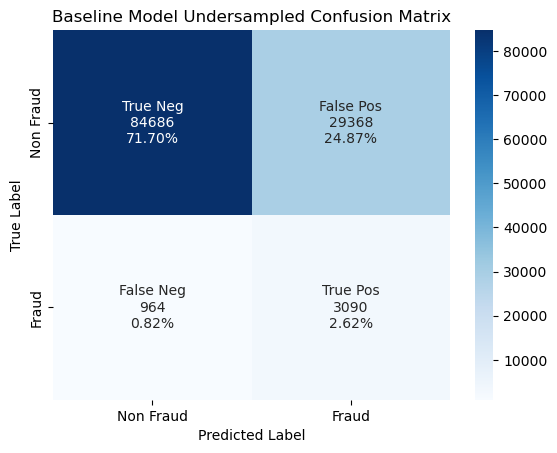

In [73]:
fig, ax = plt.subplots()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.title("Baseline Model Undersampled Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])

In [74]:
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = (2 * recall * precision) / (recall + precision)
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")
print(f"AUC: {auc_keras}")

False Positive Rate: 0.2574920651621162
Recall: 0.7622101628021707
Precision: 0.09519995070552714
Accuracy: 0.7431842042876011
F1: 0.16925942156003507
AUC: 0.8371240352926064


In [75]:
K.clear_session()

## Oversampled Data

In [6]:
model2 = keras.models.load_model("baseline_model_smote/base_model_v1_epoch_04_recall0.72_auc0.85_checkpoint.h5")

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [11]:
y_pred = model2.predict(X_val)

   1/3691 [..............................] - ETA: 12:25

2023-05-30 21:37:42.738638: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3691/3691 [==============================] - 6s 2ms/step


In [12]:
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

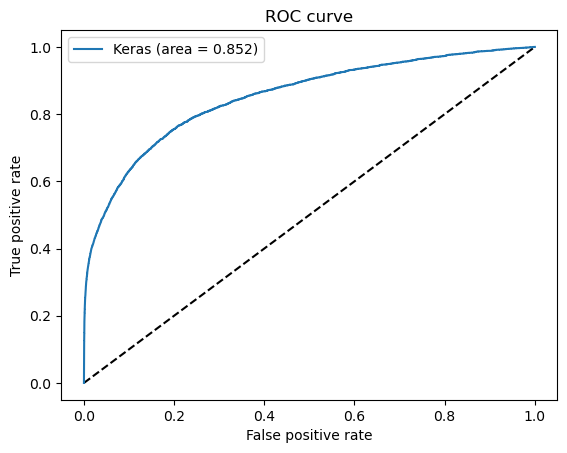

In [13]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [37]:
temp = X_val.copy()
temp['predicted'] = y_pred
temp['true'] = y_val
fraud_cases = temp[temp['true'] == 1]
non_fraud_cases = temp[temp['true']==0]

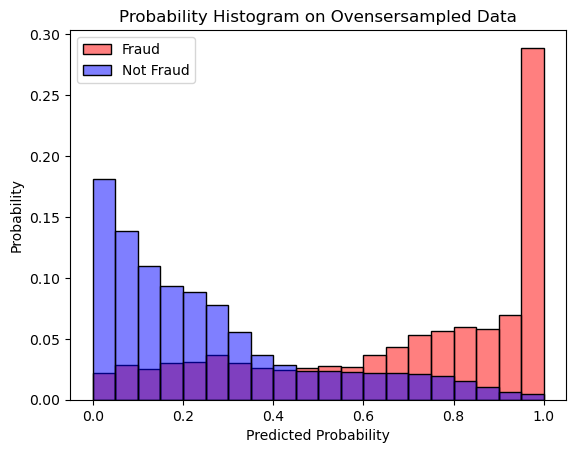

In [38]:
fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Probability Histogram on Ovensersampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

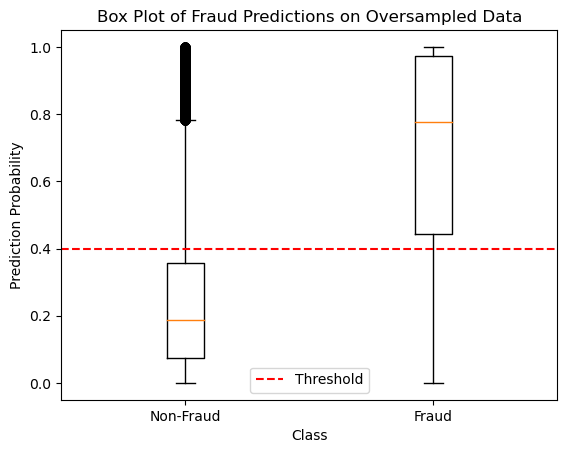

In [39]:
fraud_cases = y_pred[y_val==1]
non_fraud_cases = y_pred[y_val==0]
threshold = 0.4
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions on Oversampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Based on this, we can decide that the threshold is 0.4. Let's calculate the confusion matrix

In [30]:
y_pred_binary = (y_pred > 0.4).astype(int)
cm = confusion_matrix(y_val, y_pred_binary)

In [31]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

[Text(0, 0.5, 'Non Fraud'), Text(0, 1.5, 'Fraud')]

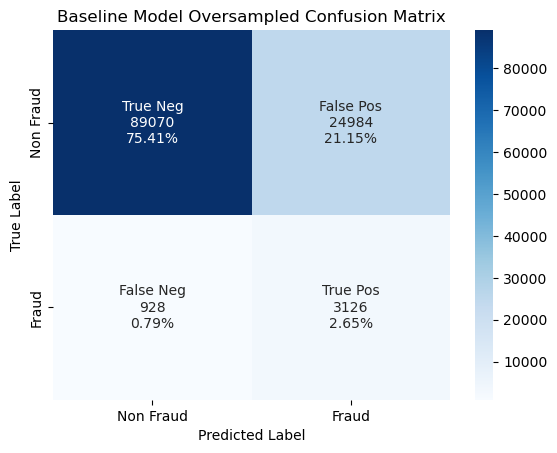

In [32]:
fig, ax = plt.subplots()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.title("Baseline Model Oversampled Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])

In [33]:
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = (2 * recall * precision) / (recall + precision)
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")
print(f"AUC: {auc_keras}")

False Positive Rate: 0.21905413225314324
Recall: 0.7710902812037493
Precision: 0.1112059765208111
Accuracy: 0.7806075795035052
F1: 0.1943788086058948
AUC: 0.8521113967609784


Undersampled:\
False Positive Rate: 0.2574920651621162\
Recall: 0.7622101628021707\
Precision: 0.09519995070552714\
Accuracy: 0.7431842042876011\
F1: 0.16925942156003507\
AUC: 0.8371240352926064

Overall, model using oversampled data yields better results